In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.0 MB/s eta 0:00:00


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadshayanumar","key":"9e275c7e45dcc320991ebe58021f3475"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!ls ~/.kaggle


kaggle.json


In [ ]:
!pip install kaggle --upgrade


In [ ]:
# Download dataset from Kaggle
!kaggle datasets download -d azouzmaroua/algeria-ultrasound-images-thyroid-dataset-auitd

Dataset URL: https://www.kaggle.com/datasets/azouzmaroua/algeria-ultrasound-images-thyroid-dataset-auitd
License(s): unknown


In [ ]:

import zipfile
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import glob
import numpy as np
import random
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ========== Reproducibility Setup ==========
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== Data Download ==========
!kaggle datasets download -d azouzmaroua/algeria-ultrasound-images-thyroid-dataset-auitd

# ========== Data Transformations ==========
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ========== Dataset & DataLoader ==========
class ThyroidDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = 2 if "normal thyroid" in img_path else (1 if "Malignant" in img_path else 0)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

def load_dataset(root_dir):
    train_paths = glob.glob(os.path.join(root_dir, "train", "*", "*.jpg"))
    test_paths = glob.glob(os.path.join(root_dir, "test", "*", "*.jpg"))
    return train_paths, test_paths

# ========== Data Preparation ==========
batch_size = 32
zip_path = "/content/algeria-ultrasound-images-thyroid-dataset-auitd.zip"
extract_path = "/content/dataset_thyroid"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

dataset_root = os.path.join(extract_path, "dataset thyroid")
if not os.path.exists(dataset_root):
    dataset_root = extract_path

train_paths, test_paths = load_dataset(dataset_root)
train_dataset = ThyroidDataset(train_paths, transform=train_transforms)
test_dataset = ThyroidDataset(test_paths, transform=test_transforms)

# Initialize generator for reproducibility
def worker_init_fn(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator()
generator.manual_seed(SEED)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    worker_init_fn=worker_init_fn,
    generator=generator,
    drop_last=True  # Ensures consistent batch sizes
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    worker_init_fn=worker_init_fn
)

# ========== Hybrid Model Architecture ==========
class HybridCNNGAT(nn.Module):
    def __init__(self):
        super(HybridCNNGAT, self).__init__()
        self.cnn = models.efficientnet_b4(weights="DEFAULT")
        for param in self.cnn.features[:-3].parameters():
            param.requires_grad = True
        self.cnn.classifier = nn.Identity()
        self.fc1 = nn.Linear(1792, 512)
        self.gat1 = pyg_nn.GATConv(512, 256, heads=4, concat=True, dropout=0.4)
        self.gat2 = pyg_nn.GATConv(256*4, 128, heads=4, concat=True, dropout=0.4)
        self.fc2 = nn.Linear(128*4, 3)

        # Initialize GAT layers with fixed seeds
        torch.manual_seed(SEED)
        self.gat1.reset_parameters()
        torch.manual_seed(SEED)
        self.gat2.reset_parameters()

    def forward(self, x, edge_index):
        cnn_features = self.cnn(x)
        x = torch.relu(self.fc1(cnn_features))
        x = self.gat1(x, edge_index)
        x = self.gat2(x, edge_index)
        return self.fc2(x)

# ========== Graph Construction ==========
def create_edge_index(num_nodes):
    edge_index = []
    for i in range(num_nodes):
        for j in range(i+1, min(i+3, num_nodes)):
            edge_index.append([i, j])
            edge_index.append([j, i])
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# ========== Training Setup ==========
model = HybridCNNGAT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
criterion = nn.CrossEntropyLoss()

# ========== Training & Evaluation ==========
def train_model():
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        edge_index = create_edge_index(len(images)).to(device)

        optimizer.zero_grad()
        outputs = model(images, edge_index)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    return total_loss/len(train_loader)

def evaluate_model():
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            edge_index = create_edge_index(len(images)).to(device)
            outputs = model(images, edge_index)
            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, preds)
    precision = precision_score(true_labels, preds, average='weighted', zero_division=1)
    recall = recall_score(true_labels, preds, average='weighted', zero_division=1)
    f1 = f1_score(true_labels, preds, average='weighted', zero_division=1)
    return accuracy, precision, recall, f1

# ========== Main Execution ==========
num_epochs = 20
best_f1 = 0

for epoch in range(num_epochs):
    train_loss = train_model()
    acc, prec, rec, f1 = evaluate_model()

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "best_model.pth")

# Load best model for final evaluation
model.load_state_dict(torch.load("best_model.pth"))
final_acc, final_prec, final_rec, final_f1 = evaluate_model()
print("\nFinal Evaluation with Best Model:")
print(f"Accuracy: {final_acc:.4f} | Precision: {final_prec:.4f}")
print(f"Recall: {final_rec:.4f} | F1 Score: {final_f1:.4f}")

Dataset URL: https://www.kaggle.com/datasets/azouzmaroua/algeria-ultrasound-images-thyroid-dataset-auitd
License(s): unknown
algeria-ultrasound-images-thyroid-dataset-auitd.zip: Skipping, found more recently modified local copy (use --force to force download)


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 131MB/s]



Final Evaluation with Best Model:
Accuracy: 0.9248 | Precision: 0.9394
Recall: 0.9248 | F1 Score: 0.9287


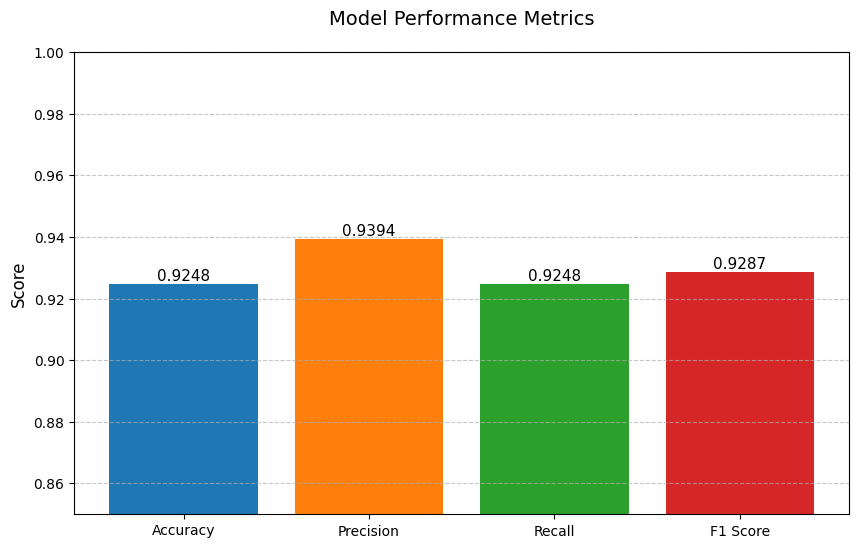

In [ ]:
import matplotlib.pyplot as plt

# Final evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [final_acc, final_prec, final_rec, final_f1]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=colors)

# Add title and labels
plt.title('Model Performance Metrics', fontsize=14, pad=20)
plt.ylabel('Score', fontsize=12)
plt.ylim(0.85, 1.0)  # Adjust y-axis to better show differences

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=11)

# Add horizontal grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

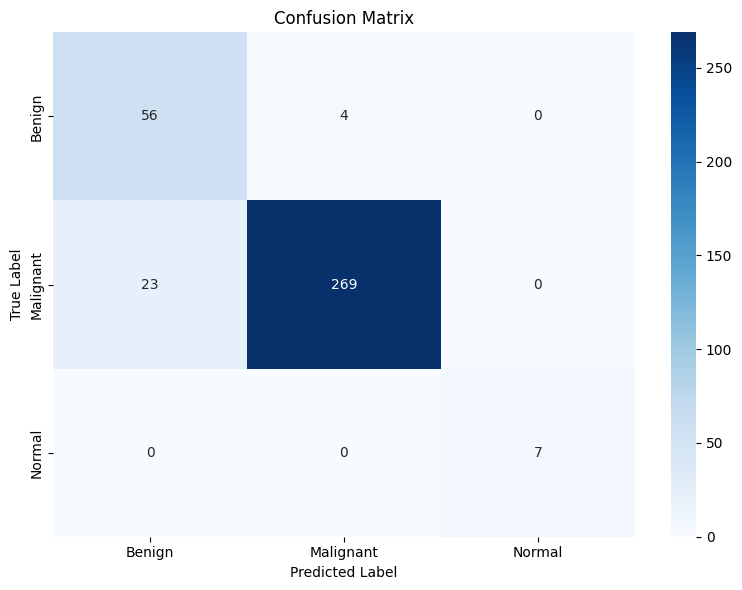

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Generate predictions and true labels for the test set ===
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        edge_index = create_edge_index(len(images)).to(device)
        outputs = model(images, edge_index)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# === Compute confusion matrix ===
cm = confusion_matrix(all_labels, all_preds)

# === Define your class labels ===
class_names = ['Benign', 'Malignant', 'Normal']

# === Plot the confusion matrix ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


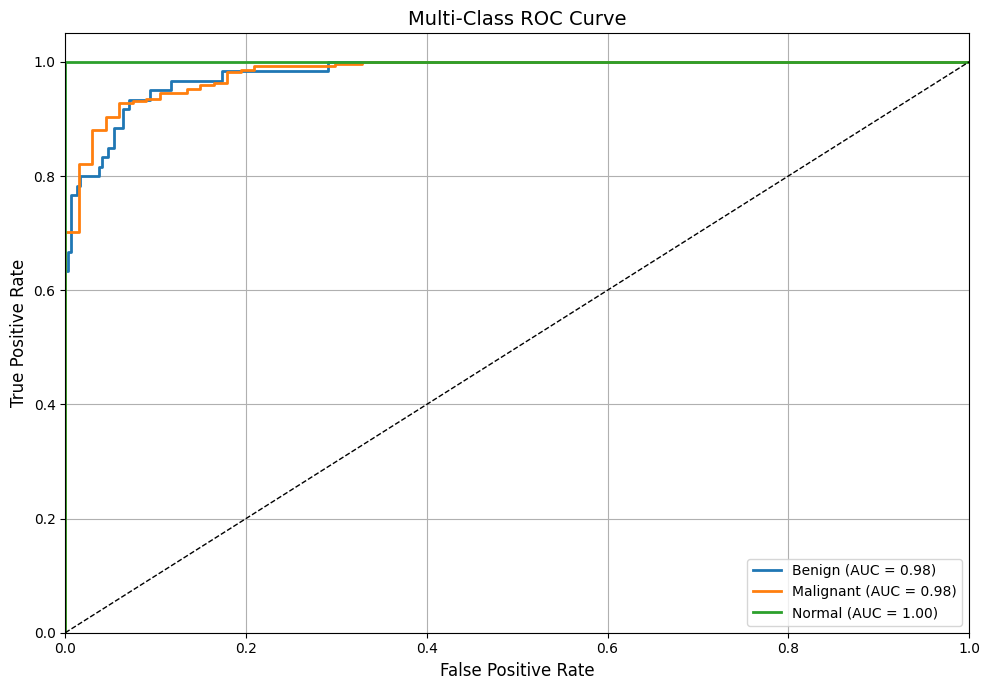

In [ ]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get predicted probabilities and true labels
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        edge_index = create_edge_index(len(images)).to(device)
        outputs = model(images, edge_index)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Step 2: Binarize the labels for multi-class ROC
n_classes = 3
y_test_bin = label_binarize(all_labels, classes=[0, 1, 2])

# Step 3: Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
class_names = ['Benign', 'Malignant', 'Normal']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Plot all ROC curves
plt.figure(figsize=(10, 7))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-Class ROC Curve', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#import os
#print(os.path.exists("best_model.pth"))  # Should print True


True


In [ ]:
#from google.colab import files
# files.download("best_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import glob
import zipfile
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download dataset from Kaggle
!kaggle datasets download -d azouzmaroua/algeria-ultrasound-images-thyroid-dataset-auitd

# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Custom Dataset Class
class ThyroidDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = 2 if "normal thyroid" in img_path else (1 if "Malignant" in img_path else 0)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load dataset
def load_dataset(root_dir):
    train_paths = (
        glob.glob(os.path.join(root_dir, "train", "Malignant", "*.jpg")) +
        glob.glob(os.path.join(root_dir, "train", "benign", "*.jpg")) +
        glob.glob(os.path.join(root_dir, "train", "normal thyroid", "*.jpg"))
    )
    test_paths = (
        glob.glob(os.path.join(root_dir, "test", "Malignant", "*.jpg")) +
        glob.glob(os.path.join(root_dir, "test", "Benign", "*.jpg")) +
        glob.glob(os.path.join(root_dir, "test", "normal thyroid", "*.jpg"))
    )
    return train_paths, test_paths

# Extract dataset
zip_path = "/content/algeria-ultrasound-images-thyroid-dataset-auitd.zip"
extract_path = "/content/dataset_thyroid"
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

dataset_root = os.path.join(extract_path, "dataset thyroid")
if not os.path.exists(dataset_root):
    dataset_root = extract_path

train_paths, test_paths = load_dataset(dataset_root)

# Create Dataset
train_dataset = ThyroidDataset(train_paths, transform=transform)
test_dataset = ThyroidDataset(test_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Define Feature Extractor (CNN)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
        self.model.classifier = nn.Identity()  # Remove final classifier

    def forward(self, x):
        return self.model(x)

# Initialize Feature Extractor
feature_extractor = FeatureExtractor().to(device)
feature_extractor.eval()

# Extract Features for SVM
def extract_features(dataloader):
    features, labels = [], []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            feats = feature_extractor(images).cpu().numpy()
            features.extend(feats)
            labels.extend(lbls)
    return np.array(features), np.array(labels)

# Extract features for training and testing
X_train, y_train = extract_features(train_loader)
X_test, y_test = extract_features(test_loader)

# Train SVM Model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train, y_train)

# Evaluate SVM Model
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Hybrid Model (CNN + SVM) Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Dataset URL: https://www.kaggle.com/datasets/azouzmaroua/algeria-ultrasound-images-thyroid-dataset-auitd
License(s): unknown
algeria-ultrasound-images-thyroid-dataset-auitd.zip: Skipping, found more recently modified local copy (use --force to force download)


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 57.2MB/s]


Hybrid Model (CNN + SVM) Results:
Accuracy: 0.8357
Precision: 0.9103
Recall: 0.8357
F1 Score: 0.8529
